# In this notebook we train ViT model.

In [1]:
import cv2
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, models, activations, metrics
from sklearn.model_selection import train_test_split
from pneumonia_utils import load_pneumonia, visualize_data, image_wrangling, image_normalize, extract_by_label
from pneumonia_models import Patches, PatchEncoder, vision_transformer

sns.set_theme()

In [ ]:
# LOAD DATA
with open('/content/drive/MyDrive/pneumonia_data/x_train.pkl', 'rb') as f:
    x_train = pickle.load(f)

with open('/content/drive/MyDrive/pneumonia_data/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('/content/drive/MyDrive/pneumonia_data/x_val.pkl', 'rb') as f:
    x_val = pickle.load(f)

with open('/content/drive/MyDrive/pneumonia_data/y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)

with open('/content/drive/MyDrive/pneumonia_data/x_test.pkl', 'rb') as f:
    x_test = pickle.load(f)

with open('/content/drive/MyDrive/pneumonia_data/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [ ]:
# As validation data (16 samples) is very small it seems to be better to perform additional split among train set
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, shuffle=True, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_validation.shape)
print(y_validation.shape)

(4172, 224, 224, 3)
(4172, 1)
(1044, 224, 224, 3)
(1044, 1)


In [ ]:
# Defining global variables (following DeiT-Ti)
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 64
PATCH_SIZE = 14
NUM_PATCHES = 256
PROJECTION_DIM = 64 # Dimension per head
TRANSFORMER_LAYERS = 6
ATTENTION_HEADS = 3
MLP_HEADS_UNITS = [2048, 1024]
CLASSES = 2
WEIGHT_DECAY = 0.005
LEARNING_RATE = 0.001
NUM_EPOCHS = 200

In [ ]:
ViT_model = vision_transformer(
    input_shape=INPUT_SHAPE,
    patch_size=PATCH_SIZE,
    num_patches=NUM_PATCHES,
    projection_dim=PROJECTION_DIM,
    transformer_layers=TRANSFORMER_LAYERS,
    num_heads=ATTENTION_HEADS,
    mlp_heads_units=MLP_HEADS_UNITS,
    num_classes=CLASSES,
    is_binary=True
)

## Training with AdamW

In [ ]:
AdamW_optimizer = tfa.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
ViT_model.compile(
    optimizer=AdamW_optimizer,
    loss="binary_crossentropy",
    metrics=[metrics.BinaryAccuracy(name="accuracy"), metrics.Recall(name="recall"), metrics.Precision(name="precision")]
)

In [ ]:
checkpoint_filepath = "/content/drive/MyDrive/checkpointAdamW"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
)

In [ ]:
history = ViT_model.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS,
        validation_data=(x_validation, y_validation),
        callbacks=[checkpoint_callback],
)

Epoch 1/200
66/66 [==============================] - 28s 236ms/step - loss: 2.8075 - accuracy: 0.6580 - recall: 0.8232 - precision: 0.7437 - val_loss: 0.5909 - val_accuracy: 0.7433 - val_recall: 1.0000 - val_precision: 0.7433
Epoch 2/200
66/66 [==============================] - 14s 207ms/step - loss: 0.5803 - accuracy: 0.7385 - recall: 0.9923 - precision: 0.7424 - val_loss: 0.5618 - val_accuracy: 0.7433 - val_recall: 1.0000 - val_precision: 0.7433
Epoch 3/200
66/66 [==============================] - 14s 209ms/step - loss: 0.5485 - accuracy: 0.7435 - recall: 0.9997 - precision: 0.7435 - val_loss: 0.4873 - val_accuracy: 0.7433 - val_recall: 1.0000 - val_precision: 0.7433
Epoch 4/200
66/66 [==============================] - 14s 208ms/step - loss: 0.4127 - accuracy: 0.8078 - recall: 0.9548 - precision: 0.8172 - val_loss: 0.2657 - val_accuracy: 0.8851 - val_recall: 0.9459 - val_precision: 0.9039
Epoch 5/200
66/66 [==============================] - 14s 205ms/step - loss: 0.2413 - accuracy: 0

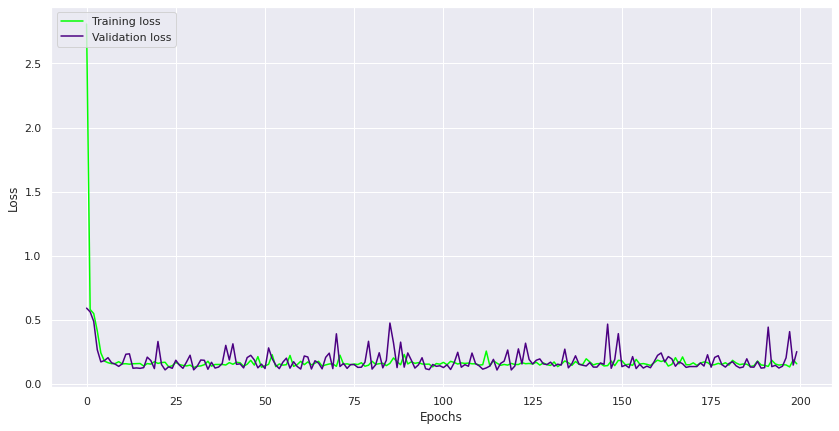

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history["loss"], color="lime", label="Training loss")
plt.plot(history.history["val_loss"], color="indigo", label="Validation loss")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("/content/drive/MyDrive/AdamW_loss.svg")
plt.show()

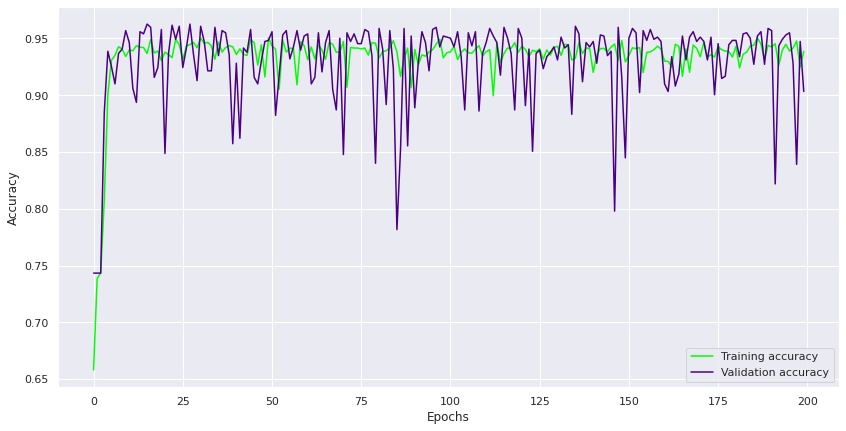

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history["accuracy"], color="lime", label="Training accuracy")
plt.plot(history.history["val_accuracy"], color="indigo", label="Validation accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("/content/drive/MyDrive/AdamW_acc.svg")
plt.show()

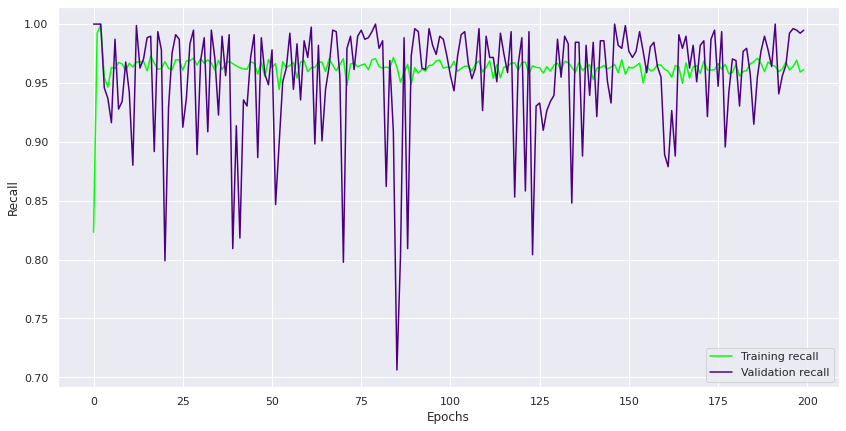

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history["recall"], color="lime", label="Training recall")
plt.plot(history.history["val_recall"], color="indigo", label="Validation recall")
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.savefig("/content/drive/MyDrive/AdamW_rec.svg")
plt.show()

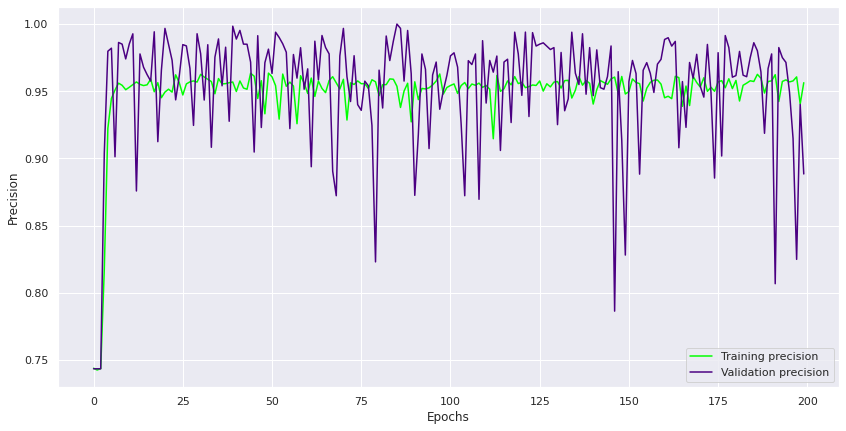

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history["precision"], color="lime", label="Training precision")
plt.plot(history.history["val_precision"], color="indigo", label="Validation precision")
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.savefig("/content/drive/MyDrive/AdamW_pre.svg")
plt.show()

In [ ]:
score = ViT_model.evaluate(x_test, y_test)

20/20 [==============================] - 1s 42ms/step - loss: 1.5212 - accuracy: 0.6458 - recall: 0.9949 - precision: 0.6392


## Training with SGD

In [ ]:
SGD_optimizer = optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9)
ViT_model.compile(
    optimizer=SGD_optimizer,
    loss="binary_crossentropy",
    metrics=[metrics.BinaryAccuracy(name="accuracy"), metrics.Recall(name="recall"), metrics.Precision(name="precision")]
)

In [ ]:
checkpoint_filepath = "/content/drive/MyDrive/checkpointSGD"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
)

In [ ]:
history = ViT_model.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS,
        validation_data=(x_validation, y_validation),
        callbacks=[checkpoint_callback],
        shuffle = True
)

Epoch 1/200
66/66 [==============================] - 24s 218ms/step - loss: 0.8079 - accuracy: 0.6843 - recall: 0.8145 - precision: 0.7728 - val_loss: 0.4784 - val_accuracy: 0.7816 - val_recall: 0.7152 - val_precision: 0.9875
Epoch 2/200
66/66 [==============================] - 12s 189ms/step - loss: 0.4188 - accuracy: 0.8164 - recall: 0.9025 - precision: 0.8577 - val_loss: 0.1940 - val_accuracy: 0.9186 - val_recall: 0.9240 - val_precision: 0.9650
Epoch 3/200
66/66 [==============================] - 11s 167ms/step - loss: 0.3078 - accuracy: 0.8725 - recall: 0.9309 - precision: 0.9007 - val_loss: 0.2530 - val_accuracy: 0.9033 - val_recall: 0.8763 - val_precision: 0.9927
Epoch 4/200
66/66 [==============================] - 13s 191ms/step - loss: 0.2421 - accuracy: 0.8979 - recall: 0.9390 - precision: 0.9247 - val_loss: 0.1584 - val_accuracy: 0.9291 - val_recall: 0.9356 - val_precision: 0.9680
Epoch 5/200
66/66 [==============================] - 11s 167ms/step - loss: 0.2230 - accuracy: 0

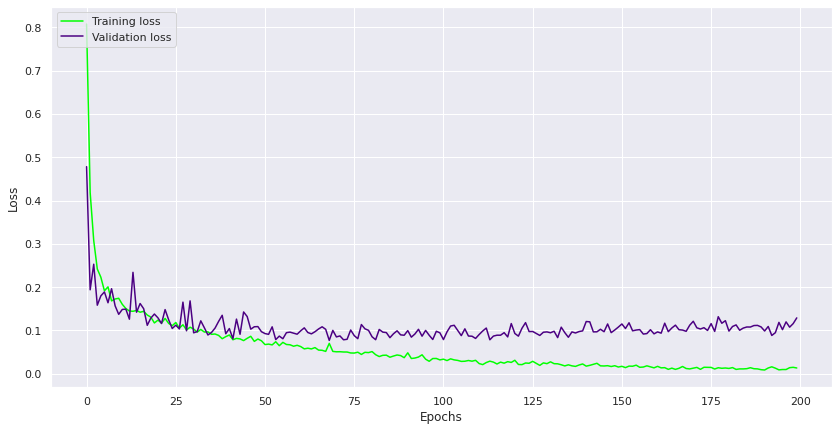

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history["loss"], color="lime", label="Training loss")
plt.plot(history.history["val_loss"], color="indigo", label="Validation loss")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("/content/drive/MyDrive/SGD_loss.svg")
plt.show()

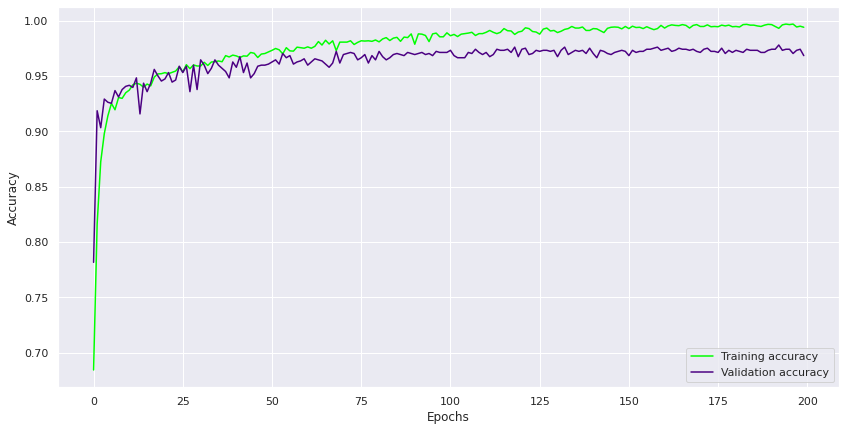

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history["accuracy"], color="lime", label="Training accuracy")
plt.plot(history.history["val_accuracy"], color="indigo", label="Validation accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("/content/drive/MyDrive/SGD_acc.svg")
plt.show()

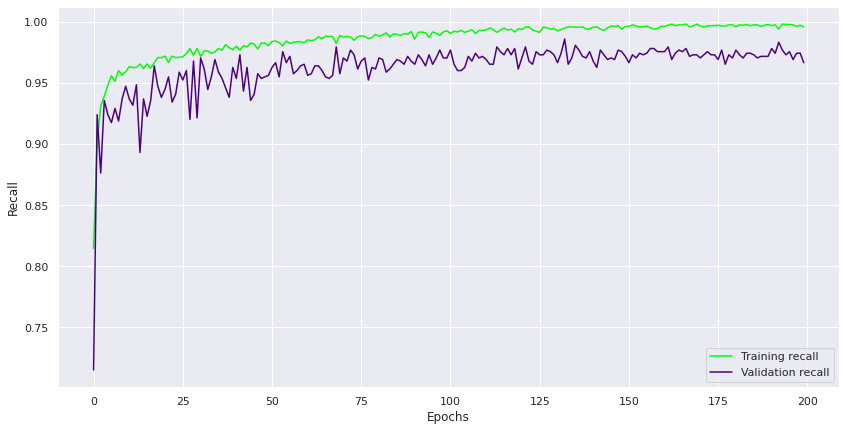

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history["recall"], color="lime", label="Training recall")
plt.plot(history.history["val_recall"], color="indigo", label="Validation recall")
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.savefig("/content/drive/MyDrive/SGD_rec.svg")
plt.show()

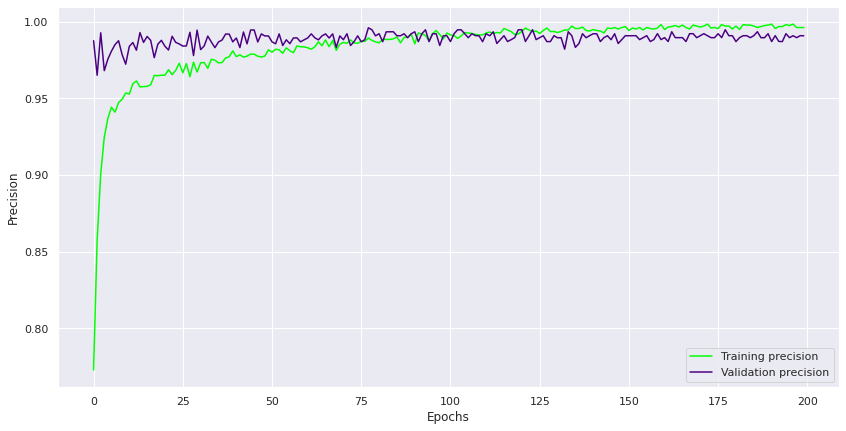

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history["precision"], color="lime", label="Training precision")
plt.plot(history.history["val_precision"], color="indigo", label="Validation precision")
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.savefig("/content/drive/MyDrive/SGD_pre.svg")
plt.show()

In [ ]:
score = ViT_model.evaluate(x_test, y_test)

20/20 [==============================] - 1s 41ms/step - loss: 1.6648 - accuracy: 0.7901 - recall: 0.9795 - precision: 0.7564
